---
layout: exercises
chapter: 3
chapter-title: Classification
permalink: /ml-book/chapter3/exercises.html
---

## Exercise 1

Build an MNIST classifier that achieves of 97% accuracy for the test set.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

# MNIST changed to https://www.openml.org/d/554
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
# Do this to follow along with Geron
def sort_by_target(mnist):
    reorder_train = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[:60000])])
    )[:, 1]
    reorder_test = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[60000:])])
    )[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
# Shuffling
shuf_order = np.random.permutation(len(y_train))
X_train, y_train = X_train[shuf_order, :], y_train[shuf_order]

(70000, 784) (70000,)


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()

cross_val_score(knn_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.97316667, 0.97241667, 0.968     , 0.96791667, 0.97158333])

In [4]:
# Pretty close right off the bat
# Let's try GridSearch
params = [dict(n_neighbors=list(range(5, 10)), weights=["uniform", "distance"])]

gs = GridSearchCV(
    knn_clf, param_grid=params, cv=5, scoring="accuracy", verbose=4, n_jobs=4
)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid=[{'n_neighbors': [5, 6, 7, 8, 9],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=4)

In [5]:
cvres = gs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9706166666666667 {'n_neighbors': 5, 'weights': 'uniform'}
0.9719833333333334 {'n_neighbors': 5, 'weights': 'distance'}
0.9691166666666667 {'n_neighbors': 6, 'weights': 'uniform'}
0.9722 {'n_neighbors': 6, 'weights': 'distance'}
0.9697999999999999 {'n_neighbors': 7, 'weights': 'uniform'}
0.9710333333333333 {'n_neighbors': 7, 'weights': 'distance'}
0.9679333333333332 {'n_neighbors': 8, 'weights': 'uniform'}
0.97065 {'n_neighbors': 8, 'weights': 'distance'}
0.9675833333333334 {'n_neighbors': 9, 'weights': 'uniform'}
0.9689166666666666 {'n_neighbors': 9, 'weights': 'distance'}


In [6]:
final_model = gs.best_estimator_
final_preds = final_model.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, final_preds)
# Barely better : /, but we pass the exercise

0.9709

## Exercise 2

Augment the training set by writing a function which shifts each image in the training set by one pixel in each of the four directions (up, down, left, right).

Text(0.5, 1.0, 'Left Shift')

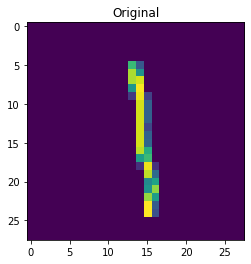

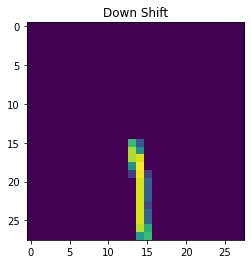

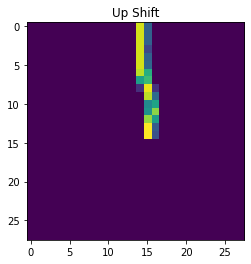

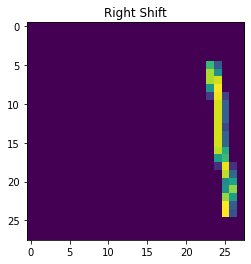

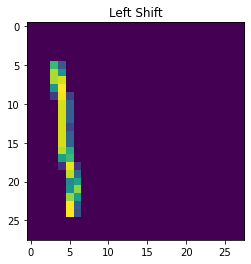

In [8]:
from scipy.ndimage import shift
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape((28, 28)))
plt.title("Original")
plt.figure()
plt.imshow(shift(X_train[0].reshape((28, 28)), [10, 0], cval=0).astype(int))
plt.title("Down Shift")
plt.figure()
plt.imshow(shift(X_train[0].reshape((28, 28)), [-10, 0], cval=0).astype(int))
plt.title("Up Shift")
plt.figure()
plt.imshow(shift(X_train[0].reshape((28, 28)), [0, 10], cval=0).astype(int))
plt.title("Right Shift")
plt.figure()
plt.imshow(shift(X_train[0].reshape((28, 28)), [0, -10], cval=0).astype(int))
plt.title("Left Shift")

In [9]:
def aug(x, y):
    new_x = []
    new_y = []
    for xi, yi in zip(x, y):
        im = xi.reshape((28, 28))
        down = shift(im, [1, 0], cval=0).astype(int)
        up = shift(im, [-1, 0], cval=0).astype(int)
        right = shift(im, [0, 1], cval=0).astype(int)
        left = shift(im, [0, -1], cval=0).astype(int)
        for v in [im, down, up, right, left]:
            new_x.append(v.flatten())
            new_y.append(yi)
    return np.array(new_x), np.array(new_y)


X_train_aug, y_train_aug = aug(X_train, y_train)

In [10]:
len(X_train), len(X_train_aug)

(60000, 300000)

In [11]:
knn_clf_aug = KNeighborsClassifier(**gs.best_params_)
knn_clf_aug.fit(X_train_aug, y_train_aug)
final_preds_aug = knn_clf_aug.predict(X_test)
accuracy_score(y_test, final_preds_aug)

0.9772

That's a ~0.63% improvement! (Subject to random seeds)

## Exercise 3

Do Kaggle Titanic. See [here](https://www.kaggle.com/code/rileypeterson/titanic).

## Exercise 4
Build a spam classifier...

From [here](https://spamassassin.apache.org/old/publiccorpus/readme.html):

    > OK, now onto the corpus description.  It's split into three parts, as follows:

      - spam: 500 spam messages, all received from non-spam-trap sources.

      - easy_ham: 2500 non-spam messages.  These are typically quite easy to
        differentiate from spam, since they frequently do not contain any spammish
        signatures (like HTML etc).

In [1]:
import requests
import tarfile
from io import BytesIO


def fetch_spam_tar(url):
    d = dict()
    r = requests.get(url, stream=True)
    with tarfile.open(fileobj=BytesIO(r.raw.read()), mode="r:bz2") as f:
        i = 0
        for member in f.getmembers():
            txt = f.extractfile(member)
            if txt and "." in member.name:
                #                 print(member.name)
                d[i] = {"filename": member.name, "bytes": txt.read()}
                i += 1
    return d


spam_dict = fetch_spam_tar(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2"
)
easy_ham_dict = fetch_spam_tar(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2"
)
print(len(spam_dict))
print(len(easy_ham_dict))

500
2500


In [2]:
from email import policy
from email.parser import BytesParser

b = BytesParser(policy=policy.default)
e = b.parsebytes(spam_dict[0]["bytes"])
for k, v in spam_dict.items():
    spam_dict[k]["email"] = b.parsebytes(v["bytes"])
for k, v in easy_ham_dict.items():
    easy_ham_dict[k]["email"] = b.parsebytes(v["bytes"])

In [3]:
print(e.keys())
print(e.get_content())

['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'From', 'Received', 'To', 'Subject', 'Date', 'MIME-Version', 'Message-ID', 'Content-Type', 'Content-Transfer-Encoding']
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 7

In [4]:
# Let's make a dataset
import pandas as pd

dataset = {"email": [], "is_spam": []}
for k, v in spam_dict.items():
    dataset["email"].append(v["email"])
    dataset["is_spam"].append(1)
for k, v in easy_ham_dict.items():
    dataset["email"].append(v["email"])
    dataset["is_spam"].append(0)

df = pd.DataFrame(data=dataset)
df

,email,is_spam
0,"[Return-Path, Delivered-To, Received, Received...",1
1,"[Return-Path, Delivered-To, Received, Received...",1
2,"[Return-Path, Delivered-To, Received, Received...",1
3,"[Return-Path, Delivered-To, Received, Received...",1
4,"[Return-Path, Delivered-To, Received, Received...",1
...,...,...
2995,"[Return-Path, Delivered-To, Received, Received...",0
2996,"[Return-Path, Delivered-To, Received, Received...",0
2997,"[Return-Path, Delivered-To, Received, Received...",0
2998,"[Return-Path, Delivered-To, Received, Received...",0


In [5]:
print(df.iloc[0, 0].get_content())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_df

,email,is_spam
642,"[Return-Path, Delivered-To, Received, Received...",0
700,"[Return-Path, Delivered-To, Received, Received...",0
226,"[Return-Path, Delivered-To, Received, Received...",1
1697,"[Return-Path, Delivered-To, Received, Received...",0
1010,"[Return-Path, Delivered-To, Received, Received...",0
...,...,...
1638,"[Return-Path, Delivered-To, Received, Received...",0
1095,"[Return-Path, Delivered-To, Received, Received...",0
1130,"[Return-Path, Delivered-To, Received, Received...",0
1294,"[Return-Path, Delivered-To, Received, Received...",0


In [7]:
spam_e = train_df.loc[train_df["is_spam"] == 1, "email"].iloc[0]
safe_e = train_df.loc[train_df["is_spam"] == 0, "email"].iloc[0]

In [8]:
# Explore data...
keys = sorted(set(list(spam_e.keys()) + list(safe_e.keys())))
view_dict = {"key": [], "spam": [], "safe": []}
for k in keys:
    view_dict["key"].append(k)
    view_dict["spam"].append(spam_e.get(k, "None"))
    view_dict["safe"].append(safe_e.get(k, "None"))
pd.set_option("display.max_rows", None)
pd.DataFrame(view_dict)

,key,spam,safe
0,Content-Transfer-Encoding,8bit,None
1,Content-Type,"text/plain; charset=""us-ascii""","text/plain; encoding=""utf-8"""
2,Date,"Wed, 04 Sep 2002 20:20:31 +0100","Tue, 08 Oct 2002 08:01:04 -0000"
3,Delivered-To,zzzz@localhost.spamassassin.taint.org,zzzz@localhost.spamassassin.taint.org
4,Errors-To,social-admin@linux.ie,None
5,From,"""MRS. M. SESE SEKO"" <maseko_h3@37.com>",guardian <rssfeeds@spamassassin.taint.org>
6,List-Id,Irish Linux Users' Group social events <social...,None
7,MIME-Version,1.0,None
8,Message-Id,<200209051817.TAA02651@lugh.tuatha.org>,<200210080801.g98814K06118@dogma.slashnull.org>
9,Precedence,bulk,None


In [9]:
# Let's get a list of the most common message header field names
from collections import Counter

d = Counter()
for e in train_df["email"].tolist():
    #     print(list(e.keys()))
    d.update(set(e.keys()))
print(d.most_common(25))

[('Date', 2400), ('From', 2400), ('Subject', 2400), ('Return-Path', 2394), ('Received', 2293), ('To', 2278), ('Delivered-To', 2271), ('Message-Id', 2233), ('Content-Type', 2059), ('MIME-Version', 1482), ('Precedence', 1422), ('List-Unsubscribe', 1296), ('Sender', 1290), ('List-Id', 1250), ('Errors-To', 1231), ('X-Beenthere', 1225), ('X-Mailman-Version', 1225), ('List-Subscribe', 1190), ('List-Help', 1188), ('List-Post', 1184), ('List-Archive', 1149), ('Content-Transfer-Encoding', 912), ('X-Mailer', 860), ('In-Reply-To', 821), ('Reply-To', 726)]


### We're going to write a pipeline that does the following:
* Gets text content (either plain text or html) 
* Convert to lowercase
* Remove punctuation
* Replace URLs with URL
* Replace NUMBERs with NUMBER
* Perform stemming
* Perform TfidfTransformer
* Extract the following header values as independent features:
  * "Content-Transfer-Encoding"
  * "Content-Type"
  * "Errors-To"
  * "List-Id"
  * "Subject"
  * "MIME-Version"
  * "Precedence"
  * "List-Unsubscribe"
  * "From"
  * is_attachment
  * is_multipart
  * content_type

In [10]:
import string
from bs4 import BeautifulSoup as bs
from sklearn.base import BaseEstimator, TransformerMixin
from urlextract import URLExtract
from nltk.stem.porter import PorterStemmer
import numpy as np
import re
import random

url_extractor = URLExtract()
stemmer = PorterStemmer()


class EmailTransformToText(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        strip=True,
        lower=True,
        remove_punc=True,
        replace_urls=True,
        replace_nums=True,
        stem=True,
        convert_html_to_text=True,
    ):
        self.strip = strip
        self.lower = lower
        self.remove_punc = remove_punc
        self.replace_urls = replace_urls
        self.replace_nums = replace_nums
        self.stem = stem
        self.convert_html_to_text = convert_html_to_text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        new_X = []
        for e in X:
            txt = self.retrieve_email_text(e)
            if self.replace_urls:
                urls = list(set(url_extractor.find_urls(txt)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    txt = txt.replace(url, " URL ")
            if self.replace_nums:
                txt = re.sub(r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", " NUMBER ", txt)
            if self.convert_html_to_text:
                txt = bs(txt).text
            if self.lower:
                txt = txt.lower()
            if self.remove_punc:
                txt = txt.translate(str.maketrans("", "", string.punctuation))
            if self.strip:
                # Also removes punctuation completely
                txt = re.sub(r"\W+", " ", txt, flags=re.M)
            if self.stem:
                # s.stem("Goosebumps in a zoo are golden potatoes chaotic beauties will stumbles computers")
                # Out[24]: 'goosebumps in a zoo are golden potatoes chaotic beauties will stumbles comput'
                txt = stemmer.stem(txt)
            if self.strip:
                txt = txt.strip()
            new_X.append(txt)
        return np.array(new_X)

    @staticmethod
    def retrieve_email_text(e) -> str:
        for part in e.walk():
            ct = part.get_content_type()
            if ct in {"text/plain", "text/html"}:
                try:
                    return part.get_content()
                except LookupError:
                    pass
        return e.get_payload()


# Just a test
# for email in train_df["email"].tolist():
#     txt = retrieve_email_text(email)
#     if not isinstance(txt, str):
#         raise ValueError

In [11]:
et = EmailTransformToText()
et.fit_transform([train_df["email"].tolist()[random.randint(0, 500)]])

array(['im using simple dns from jhsoft we support only a few web sites and id like to swap secondary services with someone in a similar position we have a static ip dsl line and a number number set of web sql mail and now a dns server as i said we are hosting about number web sites web and dns traffic is almost nothing everything is on lightly loaded apc battery backups so we are very seldom down id like to swap with someone also using simple dns to take advantage of the trusted zone file transfer option bob musser database services inc makers of process servers toolbox courier service toolbox bobmdbsinfocom url number longhorn road winter park fl number number number number'],
      dtype='<U676')

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

samp = et.fit_transform(train_df["email"].head(500).values)
vectorizer = TfidfVectorizer(max_features=300)
vectorizer.fit_transform(samp).toarray().shape

(500, 300)

In [13]:
vectorizer

TfidfVectorizer(max_features=300)

In [20]:
# Let's just put each one of these features into our training data
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer

header_attrs = [
    "Content-Transfer-Encoding",
    "Content-Type",
    "Errors-To",
    "List-Id",
    "Subject",
    "MIME-Version",
    "Precedence",
    "List-Unsubscribe",
    "From",
]


def ind_expander(arr, keys=None):
    if keys is None:
        keys = header_attrs
    e = arr[0]
    v = []
    for k in keys:
        val = e.get(k, failobj=np.nan)
        if isinstance(val, str):
            val = val.lower()
        v.append(val)
    v.append(e.is_multipart())
    v.append(e.get_content_type().lower())
    return np.array(v)


def expander(arr):
    return np.apply_along_axis(ind_expander, 1, arr)


mapper = DataFrameMapper(
    [
        ("is_spam", None),
        (["email"], FunctionTransformer(expander)),
    ],
    df_out=True,
)
prep_train_df = mapper.fit_transform(train_df)
prep_train_df.columns = ["is_spam"] + header_attrs + ["is_multipart", "content_type"]

In [21]:
for col in prep_train_df.columns:
    if col in ["is_spam", "email"]:
        continue
    vc = pd.value_counts(prep_train_df[col], dropna=False)
    vc = vc.loc[vc >= 10]
    print(vc)

nan                 1487
7bit                 636
8bit                 219
quoted-printable      55
Name: Content-Transfer-Encoding, dtype: int64
text/plain; charset="us-ascii"                727
text/plain; encoding="utf-8"                  508
nan                                           338
text/plain; charset="iso-8859-1"              250
text/plain; charset="us-ascii"; format="fl    127
text/html; charset="iso-8859-1"                84
text/plain                                     50
text/plain; charset="windows-1252"             35
multipart/alternative; boundary="----=_nex     29
text/html; charset="us-ascii"                  27
multipart/signed; micalg="pgp-sha1"; proto     22
multipart/mixed; boundary="----=_nextpart_     21
text/html                                      18
text/plain; charset="iso-8859-15"              17
text/plain; format="flowed"                    17
text/plain; charset="iso-8859-1"; format="     17
Name: Content-Type, dtype: int64
nan                  

In [97]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_rows", None)


class EmailHeaderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        out = expander(X.reshape((-1, 1)))
        return out


class HeaderArrayEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, header_count=10):
        self.header_count = header_count
        self.counter = dict()

    def fit(self, X, y=None):
        df = pd.DataFrame(
            columns=header_attrs + ["is_multipart", "content_type"], data=X
        )
        for col in df.columns:
            self.counter.update({col: Counter()})
            self.counter[col].update(df[col].tolist())
        exceeding_counts = dict()
        for col in df.columns:
            c = self.counter[col]
            exceeding_counts[col] = Counter(dict(c.most_common(9)))
            c = exceeding_counts[col]
            exceeding_counts[col] = Counter(
                i for i in c.elements() if c[i] >= self.header_count
            )

        self.counter = exceeding_counts
        return self

    def transform(self, X, y=None):
        if not self.counter:
            raise ValueError("Need counter to be initialized.")
        df = pd.DataFrame(
            columns=header_attrs + ["is_multipart", "content_type"], data=X
        )
        for col in df.columns:
            c = self.counter[col]
            df.loc[~df[col].isin(c.keys()), col] = "other"
        return df.values


def full_pipeline(header_count=10, tfid_max_features=100):

    email_pipe = Pipeline(
        [
            ("email_to_text", EmailTransformToText()),
            ("text_to_vector", CountVectorizer(max_features=tfid_max_features)),
        ]
    )

    header_pipe = Pipeline(
        [
            ("header_transformer", EmailHeaderTransformer()),
            ("header_encoder", HeaderArrayEncoder(header_count=header_count)),
            ("onehot_encoder", OneHotEncoder()),
        ],
    )

    full_pipe = FeatureUnion(
        [
            ("email_pipe", email_pipe),
            ("header_pipe", header_pipe),
        ]
    )
    return full_pipe


pipe = full_pipeline(header_count=10, tfid_max_features=500)
X = pipe.fit_transform(train_df["email"].values)
y = train_df["is_spam"].values
X_test = pipe.transform(test_df["email"].values)
y_test = test_df["is_spam"].values
print(X.shape, y.shape)

(2400, 583) (2400,)


In [98]:
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


lr_clf = LogisticRegression(solver="lbfgs", max_iter=10000, random_state=42)

cv_scores = cross_val_score(lr_clf, X, y, cv=10, scoring="accuracy")
print(cv_scores)
print(cv_scores.mean())

lr_clf.fit(X, y)


preds = lr_clf.predict(X_test)

print(f"Recall: {recall_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")

[0.99583333 1.         0.99166667 0.99166667 0.99166667 0.9875
 0.9875     0.99583333 0.99583333 1.        ]
0.99375
Recall: 0.9661016949152542
Precision: 0.991304347826087


This is pretty good. One of the main differences between this and Geron's is that he includes the number of words that don't appear in the vocabulary... 